# Visible Watermark Detection Prototype

This notebook is a prototype for training a YOLOv8 model using custom data.  More specifically, images that have been watermarked and annotated in Roboflow will be loaded and used in the pipeline.

The custom `RoboflowYOLOv8Loader` is required to load and transform data exported from Roboflow into the format and data structures required to use object detection in Tensorflow and train a YOLOv8 Model.

In [1]:
import os
import math

import keras
import keras_cv
import tensorflow as tf

# project utils
from lib.roboflow_yolov8_loader import RoboflowYOLOv8Loader
import lib.utils as utils

# Also possible to use jax or pytorch.
os.environ["KERAS_BACKEND"] = "tensorflow"

# Objects/Information we are trying to detect.
# numerical representation is based on list index.
CLASS_IDS = [
    "contact",  # contact information
    "identifier",  # image identifier
    "logo",  # a company logo
    "notice",  # copyright or other type of notice
]

DATA_DIR = "./visible-watermark-detection-VOC2007.v4i.yolov8"

BOUNDING_BOX_FORMAT = "xyxy"
BATCH_SIZE = 4

VALUE_RANGE = (0, 1)

2025-03-22 12:24:43.068662: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1742660683.085979   76444 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1742660683.090475   76444 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-03-22 12:24:43.106691: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
/home/gb/vwic/keras_cv/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update ju

## Load the visual watermark detection data

The `RoboflowYOLOv8Loader` is then used to load and split the data into different sets required in the pipeline.

In [2]:
# construct custom dataset loader.
data_loader = RoboflowYOLOv8Loader(CLASS_IDS, DATA_DIR, batch_size=BATCH_SIZE)

# load dataset.
# split percentage is managed by Roboflow and exported.
train, val, test = data_loader.load_dataset()

# verify split percentage from Roboflow
utils.view_splits(train, val, test)

100%|██████████| 690/690 [00:00<00:00, 17572.62it/s]
I0000 00:00:1742660700.734408   76444 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 5795 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 2080, pci bus id: 0000:01:00.0, compute capability: 7.5
100%|██████████| 32/32 [00:00<00:00, 19863.51it/s]

         Dataset Splits          
   Split  Percentage
0  train       87.56
1    val        8.38
2   test        4.06


## Visualize the training data

The annotated training data is visualized below to verify that the custom loader has loaded and transformed the data, and that the bounding boxes are in the correct format and are accurate.  This is critical to ensuring the object detector has accurate data when training.  The validation data is also visualized to ensure that it is correct as well.  If the validation data was incorrect then model tuning would not work well because the metrics used to tune the model during training would be incorrect.

The Keras object detection pipeline requires the dataset to be in a specific format.  When loading the dataset, we used the following structure:

```python
{
    "images": Tensor(),
    "bounding_boxes": {
        "classes": Tensor(),
        "boxes": RaggedTensor()
    }
}
```

The bounding box format needs to be translated from a python dictionary to dense bounding box tensors and this is done using the dataset `map` function.

```python
{
    "images": Tensor(),
    "bounding_boxes": DenseTensor()
}
```

In [3]:
augmenters = [
    keras_cv.layers.RandomSaturation(factor=0.1),
    keras_cv.layers.RandomBrightness(factor=0.1, value_range=VALUE_RANGE),
    keras_cv.layers.RandomContrast(factor=0.1, value_range=VALUE_RANGE),
    keras_cv.layers.RandomHue(factor=0.1, value_range=VALUE_RANGE),
    keras_cv.layers.JitteredResize(
        target_size=(640, 640),
        scale_factor=(0.9, 1.1),
        bounding_box_format=BOUNDING_BOX_FORMAT
    )
]   

def create_augmenter_fn(augmenters):
    def augmenter_fn(inputs):
        for augmenter in augmenters:
            inputs = augmenter(inputs)
        return inputs

    return augmenter_fn

augmenter_fn = create_augmenter_fn(augmenters)


resizing = keras_cv.layers.Resizing(
    640, 640, bounding_box_format=BOUNDING_BOX_FORMAT, pad_to_aspect_ratio=True
)

def dict_to_tuple(inputs):
    return inputs["images"], keras_cv.bounding_box.to_dense(
        inputs["bounding_boxes"], max_boxes=30
    )

TRAINING_SET_SIZE = len(train) # get total value before augmentation and batching
STEPS_PER_EPOCH = math.floor(TRAINING_SET_SIZE / BATCH_SIZE)
NUM_EPOCHS = 150

# load into correct format for the model
train_ds = ( train
                .shuffle(BATCH_SIZE * len(CLASS_IDS))
                .ragged_batch(BATCH_SIZE, drop_remainder=True)
                .map(augmenter_fn, num_parallel_calls=tf.data.AUTOTUNE)
                .map(dict_to_tuple, num_parallel_calls=tf.data.AUTOTUNE)
                .prefetch(tf.data.AUTOTUNE)
           )

val_ds =   ( val
                .ragged_batch(BATCH_SIZE, drop_remainder=True)
                .map(resizing, num_parallel_calls=tf.data.AUTOTUNE)
                .map(dict_to_tuple, num_parallel_calls=tf.data.AUTOTUNE)
                .prefetch(tf.data.AUTOTUNE)
           )

test_ds =  ( test
                .ragged_batch(BATCH_SIZE, drop_remainder=True)
                .map(resizing, num_parallel_calls=tf.data.AUTOTUNE)
                .map(dict_to_tuple, num_parallel_calls=tf.data.AUTOTUNE)
                .prefetch(tf.data.AUTOTUNE)
           )

TRAINING DATA


2025-03-22 12:25:25.545324: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: CANCELLED: Loop execution was cancelled.
	 [[{{node jittered_resize_1/map/while/LoopCond/_16}}]]
2025-03-22 12:25:25.629358: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: CANCELLED: Loop execution was cancelled.
	 [[{{node jittered_resize_1/map/while/LoopCond/_16}}]]
2025-03-22 12:25:25.633454: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: CANCELLED: Loop execution was cancelled.
	 [[{{node jittered_resize_1/map/while/LoopCond/_16}}]]


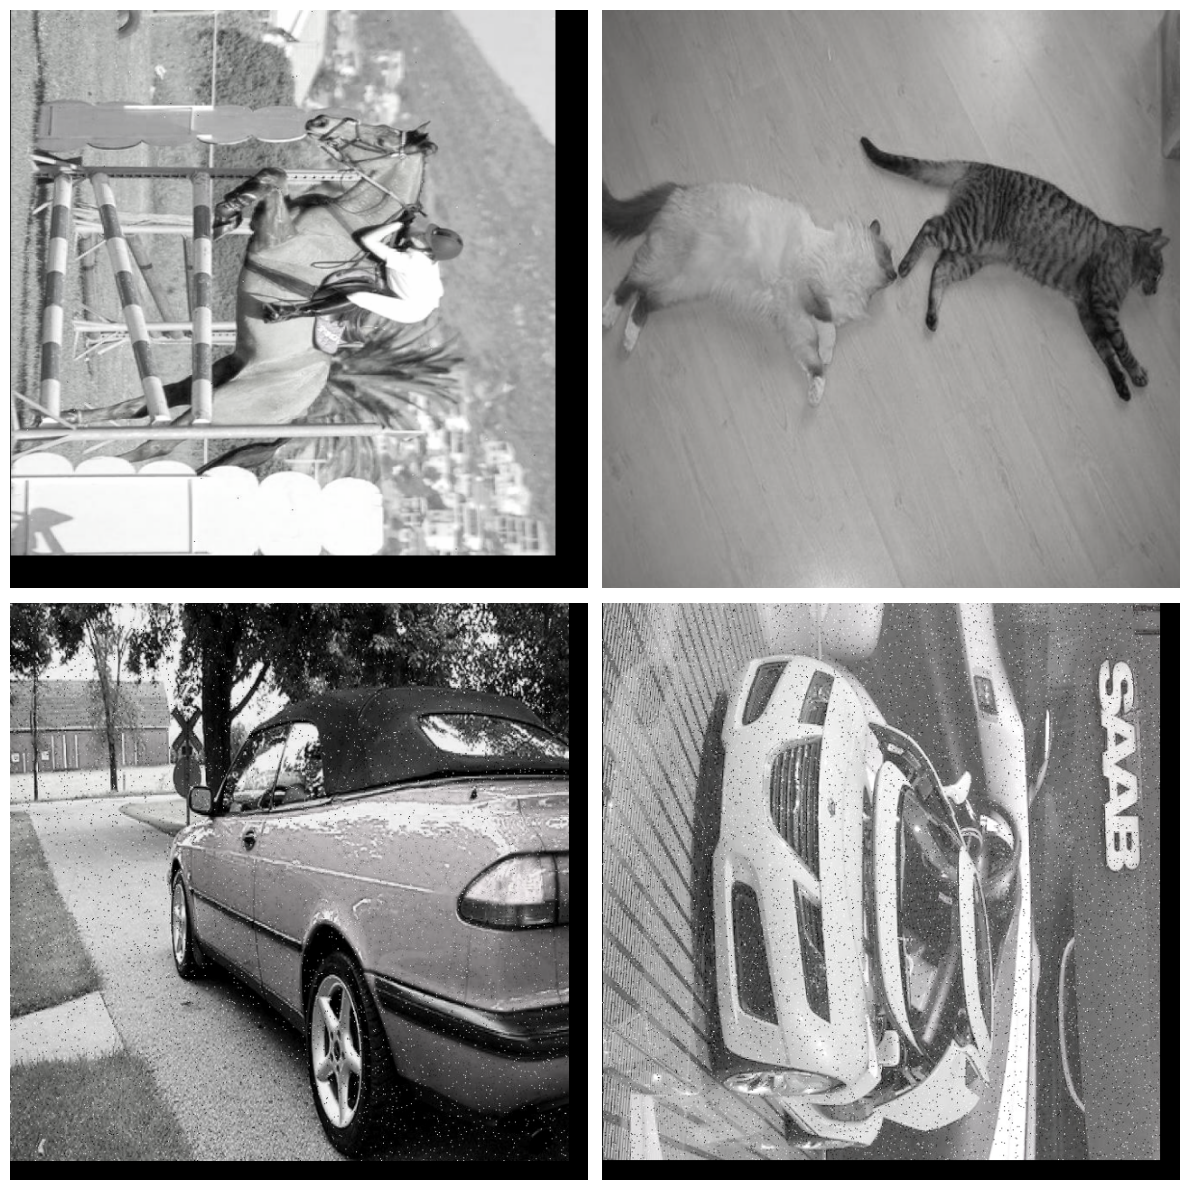

In [4]:
# visualize the training split.
print("TRAINING DATA")
utils.visualize_dataset(
    train_ds,
    data_loader.class_mapping,
    bounding_box_format=BOUNDING_BOX_FORMAT, 
    rows=2, cols=2, 
)

VALIDATION DATA


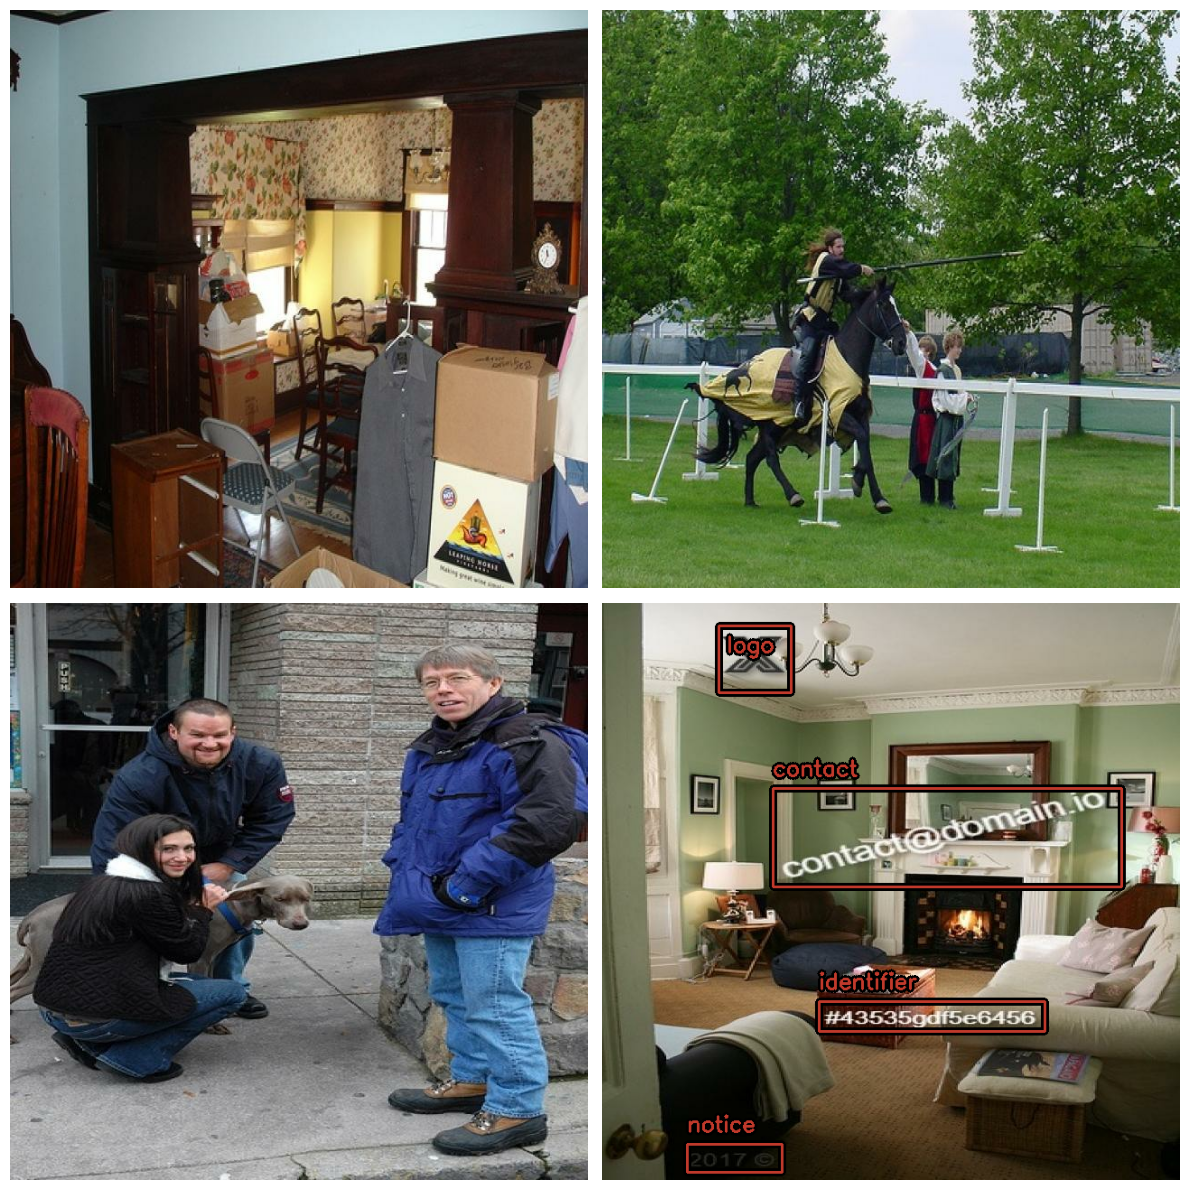

In [5]:
print("VALIDATION DATA")
utils.visualize_dataset(
    val_ds,
    data_loader.class_mapping,
    bounding_box_format=BOUNDING_BOX_FORMAT,
    rows=2,
    cols=2,
)

In [6]:
# small dataset requires small model otherwise we risk overfitting.
# load weights of backbone so that it can then be fine-tuned to the dataset.

backbone = keras_cv.models.YOLOV8Backbone.from_preset(
    "yolo_v8_s_backbone_coco", load_weights=True
)

model = keras_cv.models.YOLOV8Detector(
    num_classes=len(CLASS_IDS),
    bounding_box_format=BOUNDING_BOX_FORMAT,
    backbone=backbone,
    # fpn_depth=3,
)

initial_learning_rate = 0.0001
lr_schedule = keras.optimizers.schedules.CosineDecay(
    initial_learning_rate,
    decay_steps=math.floor(STEPS_PER_EPOCH * NUM_EPOCHS),
    alpha=0.0,
)

optimizer = keras.optimizers.Adam(learning_rate=lr_schedule, global_clipnorm = 10.0)

model.compile(
    classification_loss="binary_crossentropy",
    box_loss=keras_cv.losses.CIoULoss(bounding_box_format=BOUNDING_BOX_FORMAT),
    optimizer=optimizer,
)

## Train the YOLOv8 model using custom watermark dataset

The code below leverages functions available in the Keras computer vision library to help visualize model predictions so that they can be evaluated visually after each epoch.  This helps to understand the progress and give a visual representation of the mapping between detections and COCO metrics used when training the model.

Note: The model doesn't show very good accuracy at this stage, and doesn't have to.  With the successful training of the model, we can validate that the entire workflow (watermarking, annotation, loading and processing) works to format the data as required to train the model.

In [7]:
class VisualizeDetections(keras.callbacks.Callback):
    """Used to visualize detection progress after each epoch.
    Reference: https://keras.io/examples/vision/yolov8/
    """
    def on_epoch_end(self, epoch, logs):
        utils.visualize_detections(
            self.model,
            bounding_box_format=BOUNDING_BOX_FORMAT,
            dataset=val_ds,
            class_mapping=data_loader.class_mapping,
        )

# Train the YOLOv8 model using custom watermark image dataset.
model.fit(
    train_ds,
    validation_data=val_ds,
    steps_per_epoch=STEPS_PER_EPOCH, # matches decay_steps for regularization
    epochs=NUM_EPOCHS,  # early stopping callback may mean this is never reached.
    callbacks=[
        # Tuning the model based on metrics from this callback has been very inconsistent. 
        # This is left here for demonstration purposes, but should be replaced.
        # Github issues:
        #   - https://github.com/keras-team/keras-cv/issues/2402
        #   - https://github.com/keras-team/keras-cv/issues/2442
        keras_cv.callbacks.PyCOCOCallback(  # COCO metrics (AP/AR @ IOU)
            val_ds,
            bounding_box_format=BOUNDING_BOX_FORMAT,
        ),
        keras.callbacks.TensorBoard(  # training progress visualization
            log_dir="training_logs"
        ),
        keras.callbacks.ModelCheckpoint(
            filepath="./model/best_model.keras",
            monitor="val_loss",     # using combination of class/box loss since PyCOCOCallback unreliable.
            save_best_only=True,  # Only keep the best model
            verbose=1,
        ),
        keras.callbacks.EarlyStopping(
            patience=5,
            monitor="val_loss", # using combination of class/box loss since PyCOCOCallback unreliable.
            verbose=1,
            restore_best_weights=True,  # Restore weights of the best epoch
        ),
        # VisualizeDetections(),  # visual validation after each epoch
    ],
    # verbose=0,  # suppress epoch output since monitoring in TensorBoard.
)

Epoch 1/150


/home/gb/vwic/keras_cv/.venv/lib/python3.12/site-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor']
Received: inputs=Tensor(shape=(4, 640, 640, 3))
  warnings.warn(msg)
I0000 00:00:1742660824.571026   76519 service.cc:148] XLA service 0x7f77fc002260 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1742660824.571073   76519 service.cc:156]   StreamExecutor device (0): NVIDIA GeForce RTX 2080, Compute Capability 7.5
2025-03-22 12:27:06.821326: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1742660831.181672   76519 cuda_dnn.cc:529] Loaded cuDNN version 90300
2025-03-22 12:27:14.773341: W external/local_xla/xla/tsl/framework/bfc_allocator.cc:306] Allocator (GPU_0_bfc) ran out of memory trying to allocate 6.30GiB with freed

16/16 ━━━━━━━━━━━━━━━━━━━━ 9s 38ms/steptep - box_loss: 1.0279e-04 - class_loss: 1237.1223 - loss: 1


2025-03-22 12:28:29.112930: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


creating index...
index created!
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=0.23s).
Accumulating evaluation results...
DONE (t=0.05s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = -1.000
 

2025-03-22 12:29:30.371254: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 19663200 bytes after encountering the first element of size 19663200 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step
creating index...
index created!
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=0.00s).
Accumulating evaluation results...
DONE (t=0.01s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.000
 Average Recall     (AR) @[ IoU=0.50:0.95 

2025-03-22 12:30:00.526021: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 19663200 bytes after encountering the first element of size 19663200 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step
creating index...
index created!
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=0.00s).
Accumulating evaluation results...
Please run evaluate() first
DONE (t=0.00s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = -1.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = -1.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = -1.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = -1.000
 Avera

2025-03-22 12:30:31.310523: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 19663200 bytes after encountering the first element of size 19663200 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 41ms/step
creating index...
index created!
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=0.04s).
Accumulating evaluation results...
DONE (t=0.02s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.000
 Average Recall     (AR) @[ IoU=0.50:0.95 

2025-03-22 12:31:33.565082: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 19663200 bytes after encountering the first element of size 19663200 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 41ms/step
creating index...
index created!
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=0.00s).
Accumulating evaluation results...
Please run evaluate() first
DONE (t=0.00s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = -1.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = -1.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = -1.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = -1.000
 Avera

2025-03-22 12:32:36.528627: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


172/172 ━━━━━━━━━━━━━━━━━━━━ 30s 172ms/step - box_loss: 8.0296e-05 - class_loss: 10.8377 - loss: 10.8378 - val_box_loss: 8.0684e-05 - val_class_loss: 1.6275 - val_loss: 1.6276 - val_AP: 0.0000e+00 - val_AP50: 0.0000e+00 - val_AP75: 0.0000e+00 - val_APs: -1.0000 - val_APm: 0.0000e+00 - val_APl: 0.0000e+00 - val_ARmax1: 0.0000e+00 - val_ARmax10: 0.0000e+00 - val_ARmax100: 0.0000e+00 - val_ARs: -1.0000 - val_ARm: 0.0000e+00 - val_ARl: 0.0000e+00
Epoch 10/150
172/172 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step - box_loss: 7.9971e-05 - class_loss: 6.9969 - loss: 6.9969

2025-03-22 12:33:04.722365: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 19663200 bytes after encountering the first element of size 19663200 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 135ms/step
creating index...
index created!
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=0.00s).
Accumulating evaluation results...
Please run evaluate() first
DONE (t=0.00s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = -1.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = -1.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = -1.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = -1.000
 Aver

2025-03-22 12:34:05.281087: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 19663200 bytes after encountering the first element of size 19663200 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 42ms/step
creating index...
index created!
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=0.01s).
Accumulating evaluation results...
DONE (t=0.01s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.057
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.157
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.024
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.133
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.078
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.096
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.096
 Average Recall     (AR) @[ IoU=0.50:0.95 

2025-03-22 12:35:50.961714: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 19663200 bytes after encountering the first element of size 19663200 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 43ms/step ep - box_loss: 6.4255e-05 - class_loss: 2.1337 - lo
creating index...
index created!
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=0.07s).
Accumulating evaluation results...
DONE (t=0.02s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.077
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.152
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.065
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.145
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.091
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.133
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.152
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 

2025-03-22 12:37:26.223390: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 19663200 bytes after encountering the first element of size 19663200 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 46ms/step ep - box_loss: 5.8493e-05 - class_loss: 1.5901 - lo
creating index...
index created!
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=0.12s).
Accumulating evaluation results...
DONE (t=0.03s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.067
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.152
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.038
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.115
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.121
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.146
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.205
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 

2025-03-22 12:39:28.963294: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 19663200 bytes after encountering the first element of size 19663200 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 40ms/step
creating index...
index created!
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=0.10s).
Accumulating evaluation results...
DONE (t=0.03s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.086
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.217
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.036
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.121
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.111
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.213
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.307
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.307
 Average Recall     (AR) @[ IoU=0.50:0.95 

2025-03-22 12:39:59.300772: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 19663200 bytes after encountering the first element of size 19663200 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 47ms/step
creating index...
index created!
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=0.09s).
Accumulating evaluation results...
DONE (t=0.03s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.094
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.227
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.065
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.155
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.098
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.288
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.378
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.382
 Average Recall     (AR) @[ IoU=0.50:0.95 

2025-03-22 12:41:00.940709: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 19663200 bytes after encountering the first element of size 19663200 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 43ms/step


2025-03-22 12:41:03.008238: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


creating index...
index created!
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=0.08s).
Accumulating evaluation results...
DONE (t=0.04s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.096
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.232
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.045
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.148
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.144
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.240
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.334
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.335
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = -1.000
 

2025-03-22 12:41:29.167931: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 19663200 bytes after encountering the first element of size 19663200 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 41ms/step
creating index...
index created!
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=0.10s).
Accumulating evaluation results...
DONE (t=0.03s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.089
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.230
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.061
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.131
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.158
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.220
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.321
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.327
 Average Recall     (AR) @[ IoU=0.50:0.95 

2025-03-22 12:41:33.650615: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 19663200 bytes after encountering the first element of size 19663200 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 43ms/step ep - box_loss: 4.9817e-05 - class_loss: 0.7016 - lo
creating index...
index created!
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=0.54s).
Accumulating evaluation results...
DONE (t=0.03s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.114
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.255
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.077
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.150
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.167
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.272
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.359
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 

2025-03-22 12:42:59.399254: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 19663200 bytes after encountering the first element of size 19663200 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step
creating index...
index created!
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=0.08s).
Accumulating evaluation results...
DONE (t=0.03s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.107
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.235
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.097
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.163
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.178
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.307
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.391
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.393
 Average Recall     (AR) @[ IoU=0.50:0.95 

2025-03-22 12:43:30.055323: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 19663200 bytes after encountering the first element of size 19663200 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step
creating index...
index created!
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=0.10s).
Accumulating evaluation results...
DONE (t=0.03s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.108
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.219
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.105
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.172
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.181
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.294
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.376
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.381
 Average Recall     (AR) @[ IoU=0.50:0.95 

2025-03-22 12:43:32.629373: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 19663200 bytes after encountering the first element of size 19663200 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step ep - box_loss: 5.0117e-05 - class_loss: 0.4431 - los
creating index...
index created!
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=0.12s).
Accumulating evaluation results...
DONE (t=0.05s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.171
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.331
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.166
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.248
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.199
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.384
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.506
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100

2025-03-22 12:46:32.500109: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 19663200 bytes after encountering the first element of size 19663200 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 41ms/step
creating index...
index created!
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=0.10s).
Accumulating evaluation results...
DONE (t=0.03s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.174
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.333
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.156
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.271
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.165
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.397
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.509
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.512
 Average Recall     (AR) @[ IoU=0.50:0.95 

2025-03-22 12:50:16.995283: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 19663200 bytes after encountering the first element of size 19663200 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step
creating index...
index created!
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=0.11s).
Accumulating evaluation results...
DONE (t=0.04s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.144
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.322
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.101
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.219
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.180
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.359
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.469
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.473
 Average Recall     (AR) @[ IoU=0.50:0.95 

## Final visualization on test data

After the model has been fine-tuned with the custom training and validation data, it is essential to evaluate the models ability to generalize to unseen data.  To do this we need to use the test set, since it was not used during the training process. (Simple hold off.)

This method may be evolved as-needed throughout the project to improve the accuracy of the detector.

/home/gb/vwic/keras_cv/.venv/lib/python3.12/site-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor']
Received: inputs=Tensor(shape=(4, 640, 640, 3))
  warnings.warn(msg)


1/1 ━━━━━━━━━━━━━━━━━━━━ 7s 7s/step


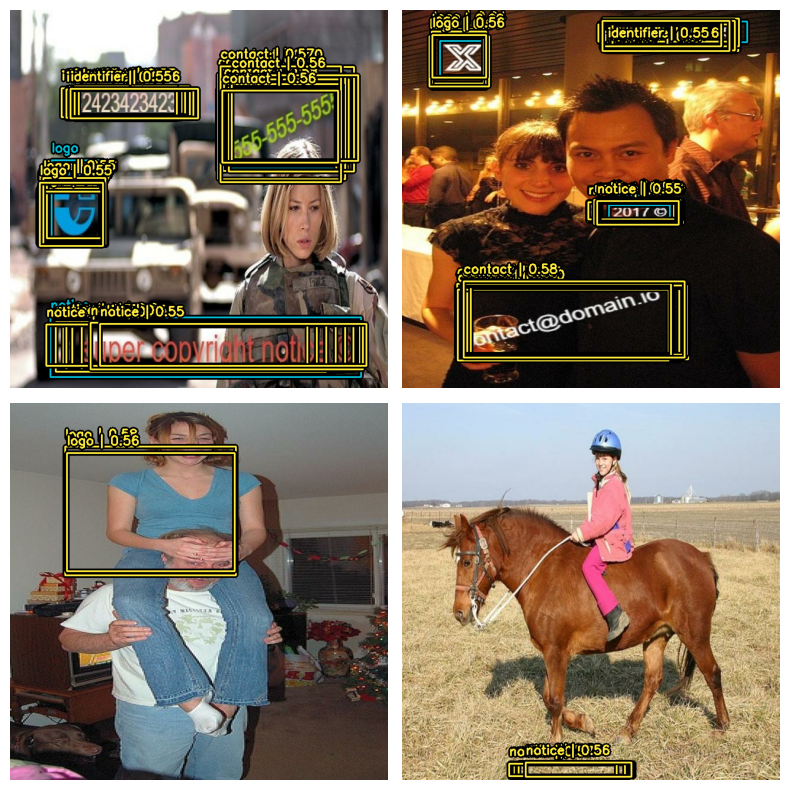

evaluating...:   0%|          | 0/8 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step


evaluating...:  12%|█▎        | 1/8 [00:00<00:02,  2.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step


evaluating...:  25%|██▌       | 2/8 [00:00<00:01,  4.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step


evaluating...:  38%|███▊      | 3/8 [00:00<00:01,  4.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step


evaluating...:  50%|█████     | 4/8 [00:00<00:00,  5.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step


evaluating...:  62%|██████▎   | 5/8 [00:01<00:00,  5.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step


evaluating...:  75%|███████▌  | 6/8 [00:01<00:00,  6.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step


evaluating...:  88%|████████▊ | 7/8 [00:01<00:00,  6.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step


evaluating...: 100%|██████████| 8/8 [00:01<00:00,  5.55it/s]


         COCO Metrics            
                         Metric     Value
0                           MaP  0.215655
1                  MaP@[IoU=50]  0.426271
2                  MaP@[IoU=75]  0.197492
3              MaP@[area=small]  0.000000
4             MaP@[area=medium]  0.282489
5              MaP@[area=large]  0.214990
6     Recall@[max_detections=1]  0.404167
7    Recall@[max_detections=10]  0.518333
8   Recall@[max_detections=100]  0.524167
9           Recall@[area=small]  0.000000
10         Recall@[area=medium]  0.535417
11          Recall@[area=large]  0.499306


In [8]:
model.prediction_decoder = keras_cv.layers.NonMaxSuppression(
    bounding_box_format=BOUNDING_BOX_FORMAT,
    from_logits=True,
    iou_threshold=0.2,
    confidence_threshold=0.55,
)

utils.visualize_detections(
    model,
    dataset=test_ds,
    bounding_box_format=BOUNDING_BOX_FORMAT,
    class_mapping=data_loader.class_mapping,
)

utils.evaluate_coco_metrics(model, test_ds, BOUNDING_BOX_FORMAT)


# References

[1] Team, Keras. “Keras Documentation: Efficient Object Detection with YOLOV8 and KerasCV.” Keras.io, keras.io/examples/vision/yolov8/.


[2] K. Team, “Keras documentation: Keras API reference,” keras.io. https://keras.io/api/
‌